In [2]:
import sys
sys.path.append('/home/ext_navish_iitkgp_gmail_com/ganRegression/')

In [3]:
import importlib

import dataset, metrics, plotting, config
from models import cgan_model
import numpy as np
import random

importlib.reload(dataset)
importlib.reload(metrics)
importlib.reload(plotting)
importlib.reload(config)
importlib.reload(cgan_model)

2022-11-18 13:40:11.685691: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-18 13:40:11.879622: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-18 13:40:11.879675: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-18 13:40:11.919674: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-18 13:40:12.779827: W tensorflow/stream_executor/platform/de

<module 'models.cgan_model' from '/home/ext_navish_iitkgp_gmail_com/ganRegression/models/cgan_model.py'>

In [18]:
import os

dataset_config = config.DatasetConfig(scenario="ailerons", n_instance=1000)

# assert(dataset_config.scenario == "linear" 
#        or dataset_config.scenario == "sinus"
#        or dataset_config.scenario == "heteroscedastic"
#        or dataset_config.scenario == "exp"
#        or dataset_config.scenario == "multi-modal"
#       )
fig_dir = f"../figures/{dataset_config.scenario}"

try:
    os.mkdir(fig_dir)
    print(f"Directory {fig_dir} created ") 
except FileExistsError:
    print(f"Directory {fig_dir} already exists replacing files in this notebook")

Directory ../figures/ailerons created 


In [13]:
exp_config = config.Config(
    model=config.ModelConfig(activation="elu", lr_gen=1e-4, dec_gen=0, lr_disc=1e-3, optim_gen="Adam", 
                             optim_disc="Adam", z_input_size=1),
    training=config.TrainingConfig(n_epochs=2000, batch_size=100, n_samples=100),
    dataset=dataset_config,
    run=config.RunConfig(save_fig=1)
)

In [8]:
# Set random seed
np.random.seed(exp_config.model.random_seed)
random.seed(exp_config.model.random_seed)

# from tensorflow import set_random_seed
# set_random_seed(exp_config.model.random_seed)

In [9]:
X_train, y_train, X_test, y_test, X_valid, y_valid = dataset.get_dataset(exp_config.dataset.n_instance, 
                                                                         exp_config.dataset.scenario)

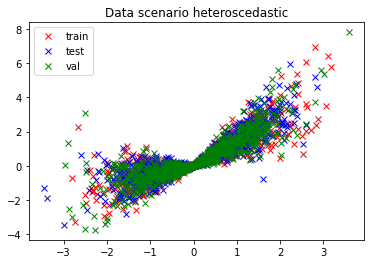

In [10]:
plotting.plot_dataset(X_train, X_test, X_valid, y_train, y_test, y_valid, exp_config, fig_dir)

# XGBoost

In [ ]:
import xgboost as xgb
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 1,eta=0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 2000)
xg_reg.fit(X_train,y_train)

#y_pred2 = xg_reg.predict(X_test)

from sklearn.metrics import mean_absolute_error

ypred_xg_test = xg_reg.predict(X_test)
xg_mae = mean_absolute_error(ypred_xg_test, y_test)
print(xg_mae)


cov_xg = np.mean((y_test - ypred_xg_test)**2)
print(metrics.gaussian_NLPD(y_test, ypred_xg_test, np.ones(len(ypred_xg_test)) * cov_xg, "XG"))

# DNN

In [ ]:
import keras

mae = []
ll = []

for i in range(10):
    kerner_initializer = keras.initializers.he_uniform(seed=exp_config.model.random_seed)
    dropout_rate = 0.1
    #use lr of 0.005 for ailerons
    # Architecture 3
    model = keras.models.Sequential([
        keras.layers.Dense(100, activation="relu", input_shape=X_train.shape[1:]), #, kernel_initializer=kerner_initializer),
        keras.layers.Dropout(dropout_rate), #, seed=exp_config.model.random_seed),
        keras.layers.Dense(50, activation="relu"), #, kernel_initializer=kerner_initializer),
        keras.layers.Dropout(dropout_rate), #, seed=exp_config.model.random_seed),
        keras.layers.Dense(50, activation="relu"), #, kernel_initializer=kerner_initializer),
        keras.layers.Dropout(dropout_rate), #, seed=exp_config.model.random_seed),
        keras.layers.Dense(50, activation="relu"), #, kernel_initializer=kerner_initializer),
        keras.layers.Dropout(dropout_rate), #, seed=exp_config.model.random_seed),
        keras.layers.Dense(50, activation="relu"), #, kernel_initializer=kerner_initializer),
        keras.layers.Dropout(dropout_rate), #, seed=exp_config.model.random_seed),
        keras.layers.Dense(50, activation="relu"), #, kernel_initializer=kerner_initializer),
        keras.layers.Dropout(dropout_rate), #, seed=exp_config.model.random_seed),
        keras.layers.Dense(1, activation="linear"), #, kernel_initializer=kerner_initializer)
    ])
    model.compile(loss="mean_squared_error", optimizer=keras.optimizers.Adam(lr=0.005, decay=0.0))
    callbacks = [keras.callbacks.EarlyStopping(patience=10)]
    history = model.fit(X_train, y_train,
                        validation_data=(X_valid, y_valid), epochs=100,
                        callbacks=callbacks)

    ypred_nn_test = model.predict(X_test)
    from sklearn.metrics import mean_absolute_error
    nn_mae = mean_absolute_error(ypred_nn_test, y_test)
    print(nn_mae)
    mae.append(nn_mae)
    cov_nn = np.mean((y_test - ypred_nn_test)**2)
    nn_nlpd = metrics.gaussian_NLPD(y_test, ypred_nn_test, np.ones(len(ypred_nn_test)) * cov_nn, "NN")
    ll.append(nn_nlpd)






In [ ]:
print(np.mean(ll))
print(np.mean(mae))

## Linear Regression 

In [ ]:
from sklearn import linear_model

regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)

ypred_linear_test = regr.predict(X_test)
ypred_linear_train = regr.predict(X_train)

## Gaussian Process 

In [ ]:
import GPy
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF

noise = 1
length = 1

run_hyperopt_search = True

kernel = GPy.kern.RBF(input_dim=1, variance=noise, lengthscale=length)
gpr = GPy.models.GPRegression(X_train, y_train, kernel)
if run_hyperopt_search:
    gpr.optimize(messages=True) 

In [ ]:
ypred_gp_test, cov_test = gpr.predict(X_test)

## GAN 

In [19]:
cgan = cgan_model.CGAN(exp_config)
d_loss_err, d_loss_true, d_loss_fake, g_loss_err, g_pred, g_true = cgan.train(X_train, y_train, 
                                                                              epochs=exp_config.training.n_epochs,
                                                                              batch_size=exp_config.training.batch_size)

ypred_gan_test = cgan.predict(X_test)

ValueError: in user code:

    File "/home/ext_navish_iitkgp_gmail_com/.local/lib/python3.8/site-packages/keras/engine/training.py", line 2041, in predict_function  *
        return step_function(self, iterator)
    File "/home/ext_navish_iitkgp_gmail_com/.local/lib/python3.8/site-packages/keras/engine/training.py", line 2027, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/ext_navish_iitkgp_gmail_com/.local/lib/python3.8/site-packages/keras/engine/training.py", line 2015, in run_step  **
        outputs = model.predict_step(data)
    File "/home/ext_navish_iitkgp_gmail_com/.local/lib/python3.8/site-packages/keras/engine/training.py", line 1983, in predict_step
        return self(x, training=False)
    File "/home/ext_navish_iitkgp_gmail_com/.local/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/ext_navish_iitkgp_gmail_com/.local/lib/python3.8/site-packages/keras/engine/input_spec.py", line 277, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer "model_10" "                 f"(type Functional).
    
    Input 0 of layer "dense_49" is incompatible with the layer: expected axis -1 of input shape to have value 674, but received input with shape (None, 1)
    
    Call arguments received by layer "model_10" "                 f"(type Functional):
      • inputs=('tf.Tensor(shape=(None, 1), dtype=float32)', 'tf.Tensor(shape=(None, 1), dtype=float32)')
      • training=False
      • mask=None


In [ ]:
plotting.plots(d_loss_err, d_loss_true, d_loss_fake, g_loss_err, g_pred, g_true, fig_dir, exp_config.run.save_fig)

In [ ]:
ypred_mean_gan_test, ypred_median_gan_test, ypred_gan_sample_test = cgan.sample(X_test, exp_config.training.n_samples)

# Plots

## Mean Predictions 

In [ ]:
plotting.plot_ypred_joint(X_test, y_test, ypred_linear_test, ypred_mean_gan_test, ypred_gp_test, 
                          "Linear-vs-GAN-vs-GP Mean Test Predictions", fig_dir=fig_dir, prefix="all_mean", 
                          save_fig=exp_config.run.save_fig)

In [ ]:
# Single GAN sample
plotting.plot_ypred_joint(X_test, y_test, ypred_linear_test, ypred_gan_test, ypred_gp_test, 
                          "Linear-vs-GAN-vs-GP Test Single GAN sample", fig_dir=fig_dir, prefix="gan_single_sample", 
                          save_fig=exp_config.run.save_fig)

## Density 

In [ ]:
sample_size_contours = 2

plot_contours = False

if plot_contours:
    # Sample from GP P(Y|X)
    ypred_gp_sample_test = np.random.normal(ypred_gp_test, np.sqrt(cov_test))
    for i in range(1, sample_size_contours):
        ypred_gp_sample_test = np.vstack([ypred_gp_sample_test, np.random.normal(ypred_gp_test, np.sqrt(cov_test))])
    
    # Sample from GAN
    _, _, ypred_gan_sample_test = cgan.sample(X_test, sample_size_contours)
    
    plotting.plot_density_cont(X_test, y_test, title="True contours", fig_dir=fig_dir, prefix="true_sample", 
                               save_fig=exp_config.run.save_fig)
    plotting.plot_density_cont(np.tile(X_test, plotting_sample_size), ypred_gp_sample_test, title="GP contours", 
                               fig_dir=fig_dir, prefix="gp_sample", save_fig=exp_config.run.save_fig)
    plotting.plot_density_cont(np.tile(X_test, plotting_sample_size), ypred_gan_sample_test, title="GAN contours", 
                               fig_dir=fig_dir, prefix="gan_sample", save_fig=exp_config.run.save_fig)

In [ ]:
plotting.plot_densities_joint(y_test, ypred_linear_test, ypred_mean_gan_test, ypred_gp_test, 
                              "Marginalized P(y) density", fig_dir=fig_dir, prefix="all_marginalized", 
                              save_fig=exp_config.run.save_fig)

## Display predictions with more samples 

In [ ]:
plotting_sample_size = 2 # inscrease sample_size to have gaussian densities for GP

In [ ]:
_, _, X_test_sample, y_test_sample, _, _ = dataset.get_dataset(exp_config.dataset.n_instance * 5, 
                                                               exp_config.dataset.scenario)

In [ ]:
ypred_mean_gan_full_test, ypred_median_gan_full_test, ypred_gan_sample_full_test = cgan.sample(X_test_sample, 
                                                                                               plotting_sample_size)

In [ ]:
ypred_gp_test_full, cov_test_full = gpr.predict(X_test_sample)

ypred_gp_sample_full_test = np.random.normal(ypred_gp_test_full[0], np.sqrt(cov_test_full[0]))
for i in range(1, len(X_test_sample)):
    ypred_gp_sample_full_test = np.vstack([ypred_gp_sample_full_test, 
                                           np.random.normal(ypred_gp_test_full[i], np.sqrt(cov_test_full[i]))])

In [ ]:
if exp_config.dataset.scenario == "linear":
    ylim=[-10, 15]
elif exp_config.dataset.scenario == "sinus" or exp_config.dataset.scenario == "heteroscedastic":
    ylim=[-4, 4]
elif exp_config.dataset.scenario == "exp":
    ylim=[-4, 9]
elif exp_config.dataset.scenario == "multi-modal":
    ylim=[-0.1, 1.1]
else:
    raise Exception("Y limits to be specified")
    
plotting.plot_ypred_joint(X_test_sample, y_test_sample, None, None, None, "True Sample", alpha=0.15, is_sample=True, 
                          fig_dir=fig_dir, prefix="true_more_sample", save_fig=exp_config.run.save_fig, ylim=ylim)

In [ ]:
plotting.plot_ypred_joint(X_test_sample, None, None, ypred_gan_sample_full_test, None, 
                          "GAN Test Predictions", alpha=0.25, is_sample=True, fig_dir=fig_dir, 
                          prefix="gan_more_sample", save_fig=exp_config.run.save_fig, ylim=ylim)

In [ ]:
plotting.plot_ypred_joint(X_test_sample, None, None, None, ypred_gp_sample_full_test, "GP Test Predictions", 
                          alpha=0.15, is_sample=False, fig_dir=fig_dir, prefix="gp_more_sample", 
                          save_fig=exp_config.run.save_fig, ylim=ylim)

## P(y|x) 

In [ ]:
if exp_config.dataset.scenario == "sinus":
    bins = [-1, 0, 1]
    ylim = [[-2.5,2.5], [-2.5,2.5], [-2.5,2.5]]
elif exp_config.dataset.scenario == "linear":
    bins = [4, 0, 10] 
    ylim = [[-5,17.5], [-5,17.5], [5,22]]
elif exp_config.dataset.scenario == "exp":
    bins = [-1, 0, 1] 
    ylim = [[-5,17.5], [-5,17.5], [5,22]]
elif exp_config.dataset.scenario == "multi-modal":
    bins = [0.4, 0.45, 0.2]
    ylim = [[0,1.1], [0,1], [0,1.1]]
elif exp_config.dataset.scenario == "heteroscedastic":
    bins = [-2,0,2]
    ylim = [[-3.2,2], [-2,2], [-2,5.5]]
else:
    raise Exception("Bins to be specified")

ind = 0
delta = 0.05

for x in bins:
    idx = np.logical_and(X_test_sample < x + delta, X_test_sample > x - delta)
    ypred_gan_sample_ = ypred_gan_sample_full_test[:, 0].reshape(-1,1)
    ypred_gp_sample_ = ypred_gp_sample_full_test[:, 0].reshape(-1,1)
    plotting.plot_densities_joint(y_test_sample[idx], None, ypred_gan_sample_[idx], ypred_gp_sample_[idx], 
                                  f"P(y|x) density at x={x}", at_x=True, fig_dir=fig_dir, prefix=f"all_at_x_{x}", 
                                  save_fig=exp_config.run.save_fig, ylim=ylim[ind])
    ind = ind + 1

# Metrics

In [ ]:
n_eval_runs = 10

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mse_gan_= []
mae_gan_ = []
for i in range(n_eval_runs):
    ypred_mean_gan_test_, ypred_median_gan_test_, _ = cgan.sample(X_test, exp_config.training.n_samples)
    mae_gan_.append(mean_absolute_error(y_test, ypred_median_gan_test_))
    mse_gan_.append(mean_squared_error(y_test, ypred_mean_gan_test_))

In [ ]:
gan_mae_mean = np.mean(np.asarray(mae_gan_))
gan_mae_std = np.std(np.asarray(mae_gan_))

print(f"Linear MAE test: {mean_absolute_error(ypred_linear_test, y_test)}")
print(f"GP MAE test: {mean_absolute_error(ypred_gp_test, y_test)}")
print(f"GAN MAE test: {gan_mae_mean} +- {gan_mae_std}")

In [ ]:
linear_mse = mean_squared_error(ypred_linear_test, y_test)
gp_mse = mean_squared_error(ypred_gp_test, y_test)
gan_mse_mean = np.mean(np.asarray(mse_gan_))
gan_mse_std = np.std(np.asarray(mse_gan_))

print(f"Linear MSE test: {linear_mse}")
print(f"GP MSE test: {gp_mse}")
print(f"GAN MSE test: {gan_mse_mean} +- {gan_mse_std}")

In [ ]:
linear_nlpd = metrics.gaussian_NLPD(y_test, ypred_linear_test, np.ones(len(ypred_linear_test)), "Linear")

In [ ]:
gp_nlpd = metrics.gaussian_NLPD(y_test, ypred_gp_test, cov_test, "GP")

In [ ]:
gan_nlpd_train, w, lls = metrics.Parzen(cgan, X_valid, y_valid)
nlpd_ = []
for i in range(n_eval_runs):
    nlpd_.append(metrics.Parzen_test(cgan, X_test, y_test, w, exp_config.training.n_samples))
gan_nlpd_test = np.mean(nlpd_)
gan_nlpd_std_test = np.std(nlpd_)
print(f"GAN Train NLPD: {gan_nlpd_train}")
print(f"GAN Test NLPD: mean {gan_nlpd_test} std {gan_nlpd_std_test}")

In [ ]:
if exp_config.run.save_fig:
    file = open(f"{fig_dir}/metrics.txt","w") 

    file.write(f"===Test MAE===\n")
    file.write(f"Linear MAE test: {mean_absolute_error(ypred_linear_test, y_test)}\n") 
    file.write(f"GP MAE test: {mean_absolute_error(ypred_gp_test, y_test)}\n")
    file.write(f"GAN MAE test: {gan_mae_mean} +- {gan_mae_std}\n")
    file.write(f"===Test MSE===\n")
    file.write(f"Linear MSE test: {linear_mse}\n")
    file.write(f"GP MSE test: {gp_mse}\n")
    file.write(f"GAN MSE test: {gan_mse_mean} +- {gan_mse_std}\n")
    file.write(f"===Test NLPD===\n")
    file.write(f"Linear Gaussian NLPD: {linear_nlpd}\n")
    file.write(f"GP Gaussian NLPD: {gp_nlpd}\n")
    file.write(f"GAN NLPD: {gan_nlpd_test} +- {gan_nlpd_std_test}\n")
    file.close() 